# Variational Quantum Eigensolver (VQE)

Cálculo de la energía mínima para una molécula de hidrógeno empleando Qiskit Nature 0.7.2

El código en cuestión es una modificación del tutorial para el cálculo de la energía base del problema electrónico presentado en [1]. Este código fue únicamente creado con la finalidad de generar gráficas con fines ilustrativos.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate

In [3]:
# solución de Hartree-Fock
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735", # hidrógeno molecular, separación interatómica = x
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

# definicíón del problema (electrónico, en este caso)
problem = driver.run()

# Hamiltoniano del problema electrónico
hamiltonian = problem.hamiltonian

# elementos de matriz (segunda cuantización)
coefficients = hamiltonian.electronic_integrals

# segunda cuantización del Hamiltoniano H2
second_q_op = hamiltonian.second_q_op()

In [4]:
# fermion-qubit mapping
mapper = JordanWignerMapper()
eigensolver = NumPyMinimumEigensolver()

In [5]:
qubit_op = mapper.map(second_q_op)
for pauli, coeff in sorted(qubit_op.label_iter()):
    print(f"{coeff.real:+.8f} * {pauli}")

-0.81054798 * IIII
+0.17218393 * IIIZ
-0.22575349 * IIZI
+0.12091263 * IIZZ
+0.17218393 * IZII
+0.16892754 * IZIZ
+0.16614543 * IZZI
+0.04523280 * XXXX
+0.04523280 * XXYY
+0.04523280 * YYXX
+0.04523280 * YYYY
-0.22575349 * ZIII
+0.16614543 * ZIIZ
+0.17464343 * ZIZI
+0.12091263 * ZZII


In [6]:
solver = GroundStateEigensolver(mapper, eigensolver)
result = solver.solve(problem)
print("Energía edo. base:", result.groundenergy)

Energía edo. base: -1.8572750302023813


## Variación distancia interatómica

In [7]:
mapper = JordanWignerMapper()
eigensolver = NumPyMinimumEigensolver()

def H2(d,mapper,solver):
  """
  d: distancia interatómica en angstrom
  """
  driver = PySCFDriver(
      atom=f"H 0 0 0; H 0 0 {d}",
      basis="sto3g",
      charge=0,
      spin=0,
      unit=DistanceUnit.ANGSTROM,
  )
  problem = driver.run()
  hamiltonian = problem.hamiltonian
  coefficients = hamiltonian.electronic_integrals
  second_q_op = hamiltonian.second_q_op()
  solver = GroundStateEigensolver(mapper, solver)
  result = solver.solve(problem).groundenergy

  return result + hamiltonian.nuclear_repulsion_energy

In [8]:
a_distance = np.arange(0.19, 4, 0.15) # distancia inter-atómica
g_energies = [H2(i,mapper,eigensolver) for i in a_distance]

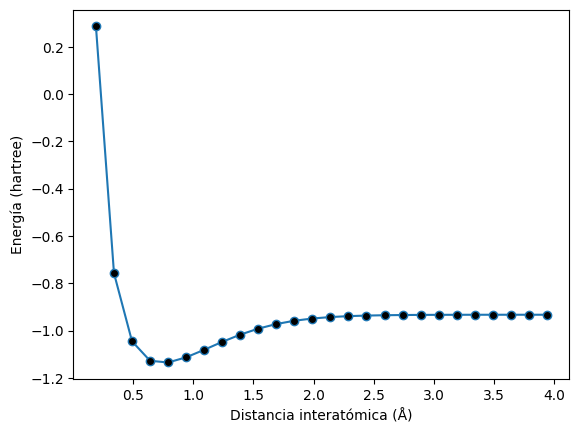

In [9]:
plt.xlabel("Distancia interatómica (Å)")
plt.ylabel("Energía (hartree)")
plt.plot(a_distance, g_energies, marker='o', markerfacecolor='k')

## Circuito

In [18]:
X = SparsePauliOp("X")
Y = SparsePauliOp("X")
Z = SparsePauliOp("Z")
I = SparsePauliOp("I")

In [19]:
operator = -0.81054798 * (I^I^I^I) + 0.17218393 * (I^I^I^Z) - 0.22575349 * (I^I^Z^I) + 0.12091263 * (I^I^Z^Z) + 0.17218393 * (I^Z^I^I) + 0.16892754 * (I^Z^I^Z) + 0.16614543 * (I^Z^Z^I) + 0.04523280 * (X^X^X^X) + 0.04523280 * (X^X^Y^Y) + 0.04523280 * (Y^Y^X^X) + 0.04523280 * (Y^Y^Y^Y) - 0.22575349 * (Z^I^I^I) + 0.16614543 * (Z^I^I^Z) + 0.17464343 * (Z^I^Z^I) + 0.12091263 * (Z^Z^I^I)
evo = PauliEvolutionGate(operator)

# hamiltoniano
H = QuantumCircuit(4, name="H")
H.append(evo, range(4))

# Psi
psi = QuantumCircuit(4, name="Psi")
psi.x([0,2])

# Psi conjugada
psi_t = QuantumCircuit(4, name="Psi_dagger")
psi_t.x([0,2])

In [20]:
style = {'displaycolor': {'Psi': ('#05BAB6', '#141414'),
                          'Psi_dagger': ('#05BAB6', '#141414'),
                          'H': ('#6FA4FF', '#141414'),
                          'measure': ('#000000', '#FFFFFF')},
         'displaytext': {'Psi': "$|\Psi(θ)⟩$",
                         'Psi_dagger': "$⟨\Psi(θ)|$",
                         'H': "$\mathcal{H}$"}}

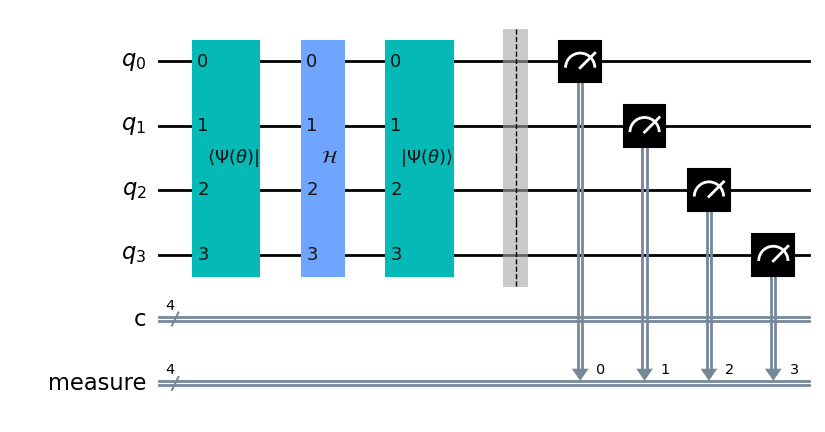

In [21]:
qc = QuantumCircuit(4,4)
qc.append(psi_t, [0,1,2,3])
qc.append(H, [0,1,2,3])
qc.append(psi, [0,1,2,3])
qc.measure_active()

qc.draw(output='mpl', style=style, cregbundle=True)

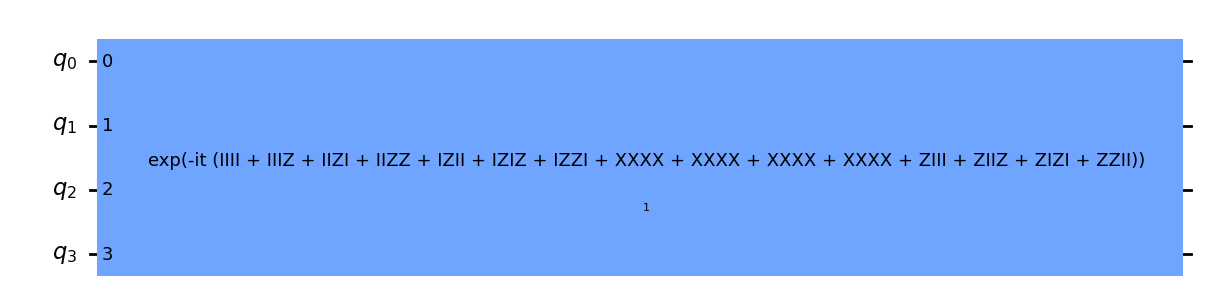

In [22]:
font = {
    "gatetextcolor": "#000000",
    "gatefacecolor": "#6FA4FF"
}
qc_H = QuantumCircuit(4, name="H")
qc_H.append(evo, range(4))
qc_H.draw(output='mpl', style=font)

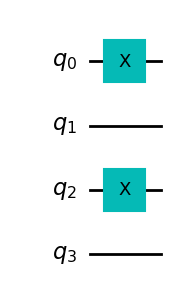

In [23]:
font = {
    "displaycolor": {
        "x": [ # gate name
            "#05BAB6", # box color (red)
            "#000000" # box text color (white)
        ]}
}
qc_psi = QuantumCircuit(4)
qc_psi.x([0,2])
qc_psi.draw(output='mpl', style=font)

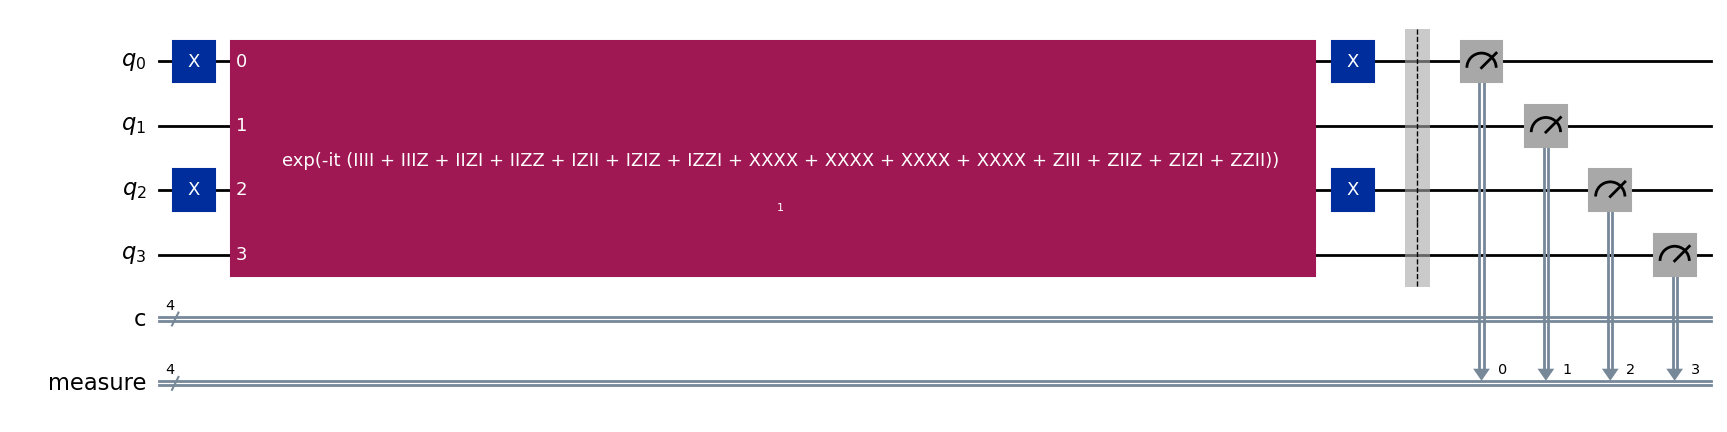

In [25]:
test = qc.decompose()
test.draw(output='mpl')

[1] https://qiskit-community.github.io/qiskit-nature/tutorials/01_electronic_structure.html